# 1.3. Image Pruning
---
Last edited: 05/02/2022 by Jeongkyung Won<br>
This code does: 
* filter out clipped images that are entirely transparent (i.e. contains no visual information)
* ensures only maps with visual information will be used to construct training/ test dataset

In [1]:
# Define Dropbox Function

import requests
import zipfile
from urllib.parse import unquote # for url string conversion
import re
from tqdm import tqdm

def download_dropbox(url, folder):
  ## version 2.0, last modified by Hyunjoo Yang (hyang@sogang.ac.kr) on Jan. 14 2022
  ## This function downloads dropbox shareable link to a local folder (tested for file downloading, but not for shared folder!)
  
  # url: dropbox shareable link for downloading
  # folder: where to download
  
  headers = {'user-agent': 'Wget/1.16 (linux-gnu)'}
  r = requests.get(url, stream=True, headers=headers)
  
  # convert dropbox shareable link ("dl=0" to "dl=1")
  url = url.replace("?dl=0", "?dl=1")

  # check if the url returns valid status code (200)
  if r.status_code == 200:
    print('The url is valid.')

    # grab filename from the url, using regular expressions (and replace space to "_" )
    file_name = unquote(re.search(r'\/([^\/]+\.([\w]+))\?dl=([01])$', url).group(1)).replace(" ", "_")

    folder_n_fname = os.path.join(folder, file_name)

    # download
    print('Begin downloading < {} >'.format(folder_n_fname))


    # Total size in bytes.
    total_size = int(r.headers.get('content-length', 0))
    block_size = 1024  # 1 Kibibyte
    t = tqdm(total=total_size, unit='B', unit_scale=True)
    with open(file_name, 'wb') as f:
      for data in r.iter_content(block_size):
        t.update(len(data))
        f.write(data)
    t.close()

    print('Finished downloading < {} >'.format(folder_n_fname))

    # unzip if zip file
    if file_name.endswith('.zip'):
      print('Extracting zip file...')
      with zipfile.ZipFile(file_name,"r") as zip_ref:
        zip_ref.extractall(folder)
    else:
      if not os.path.exists(folder):
        os.makedirs(folder)
      shutil.move(file_name, folder_n_fname)

    print('Done!')
  else:
    raise ValueError('Nothing to download: dropbox link is not valid. Check the URL link again')

In [ ]:
## dropbox shareable url link

import os

url = 'https://www.dropbox.com/s/wffqp844p7q5ejo/black_to_transparent_2km_all.zip?dl=0' # All of NGII 1970 2㎢ clipped maps (black to transparent .ver)

# file path for download and unzip
url_path = './all_maps'

# download dropbox shared file and unzip it
download_dropbox(url, url_path)

### 1.3.1. Create a deathnote : the list of images to remove 

In [ ]:
from pathlib import Path
import os.path
import pandas as pd
import glob
import numpy as np

png_dr=Path('./all_maps/cropped_black_to_transparent')

In [ ]:
png_paths=pd.Series(list(png_dr.glob(r'*.png')),name='filepath').astype(str)
png_paths[:10]

0     all_maps/cropped_black_to_transparent/9167.png
1      all_maps/cropped_black_to_transparent/825.png
2     all_maps/cropped_black_to_transparent/2854.png
3     all_maps/cropped_black_to_transparent/4950.png
4     all_maps/cropped_black_to_transparent/8764.png
5    all_maps/cropped_black_to_transparent/18043.png
6     all_maps/cropped_black_to_transparent/3995.png
7     all_maps/cropped_black_to_transparent/4643.png
8    all_maps/cropped_black_to_transparent/10322.png
9     all_maps/cropped_black_to_transparent/3514.png
Name: filepath, dtype: object

In [ ]:
png_size=pd.Series(png_paths.apply(lambda x: os.path.getsize(x)),name='filesize').astype(int)
png_size[:10]

0    258886
1       960
2    258684
3    272290
4    270323
5    265598
6       954
7       954
8       951
9    247398
Name: filesize, dtype: int64

In [ ]:
images=pd.concat([png_paths, png_size],axis=1).sample(frac=1.0,random_state=1).reset_index(drop=True)
images[:10]

,filepath,filesize
0,all_maps/cropped_black_to_transparent/15334.png,280661
1,all_maps/cropped_black_to_transparent/17212.png,275824
2,all_maps/cropped_black_to_transparent/8404.png,258566
3,all_maps/cropped_black_to_transparent/15815.png,274140
4,all_maps/cropped_black_to_transparent/10071.png,272952
5,all_maps/cropped_black_to_transparent/2181.png,277979
6,all_maps/cropped_black_to_transparent/1156.png,997
7,all_maps/cropped_black_to_transparent/8548.png,269081
8,all_maps/cropped_black_to_transparent/16410.png,254049
9,all_maps/cropped_black_to_transparent/9360.png,286927


In [ ]:
threshold=70000 

deathnote= images[images['filesize']<threshold].reset_index() ## for most cases, images with memory less than 1KB are completely transparent 

len(deathnote)

1785

In [ ]:
death_paths=deathnote['filepath']
death_paths

0        all_maps/cropped_black_to_transparent/1156.png
1        all_maps/cropped_black_to_transparent/7077.png
2       all_maps/cropped_black_to_transparent/12298.png
3        all_maps/cropped_black_to_transparent/1260.png
4       all_maps/cropped_black_to_transparent/11213.png
                             ...                       
1780    all_maps/cropped_black_to_transparent/14604.png
1781      all_maps/cropped_black_to_transparent/607.png
1782     all_maps/cropped_black_to_transparent/4625.png
1783    all_maps/cropped_black_to_transparent/14818.png
1784    all_maps/cropped_black_to_transparent/12287.png
Name: filepath, Length: 1785, dtype: object

In [ ]:
death_ids=pd.Series(death_paths.apply(lambda x: os.path.splitext(os.path.split(x)[1])[0]), name='id')
death_ids

0        1156
1        7077
2       12298
3        1260
4       11213
        ...  
1780    14604
1781      607
1782     4625
1783    14818
1784    12287
Name: id, Length: 1785, dtype: object

### 1.3.2. Check images 

In [ ]:
from tqdm import tqdm
import tensorflow as tf

# put images to array
from tensorflow.keras.utils import load_img, img_to_array

# function: image to array

def path_to_input_image(path):
    return img_to_array(load_img(path, target_size=img_size))

img_size= (200, 200)

In [ ]:
# initiate an empty array (filled with np.zeros) for images

images_to_remove = np.zeros((len(deathnote),) + img_size + (3,), dtype="uint8") ## float -> uint8 to reduce memory burden

In [ ]:
# put train images to array

for i in tqdm(range(len(deathnote))):
  images_to_remove[i] = path_to_input_image(death_paths[i])

100%|██████████| 1785/1785 [00:03<00:00, 541.72it/s]


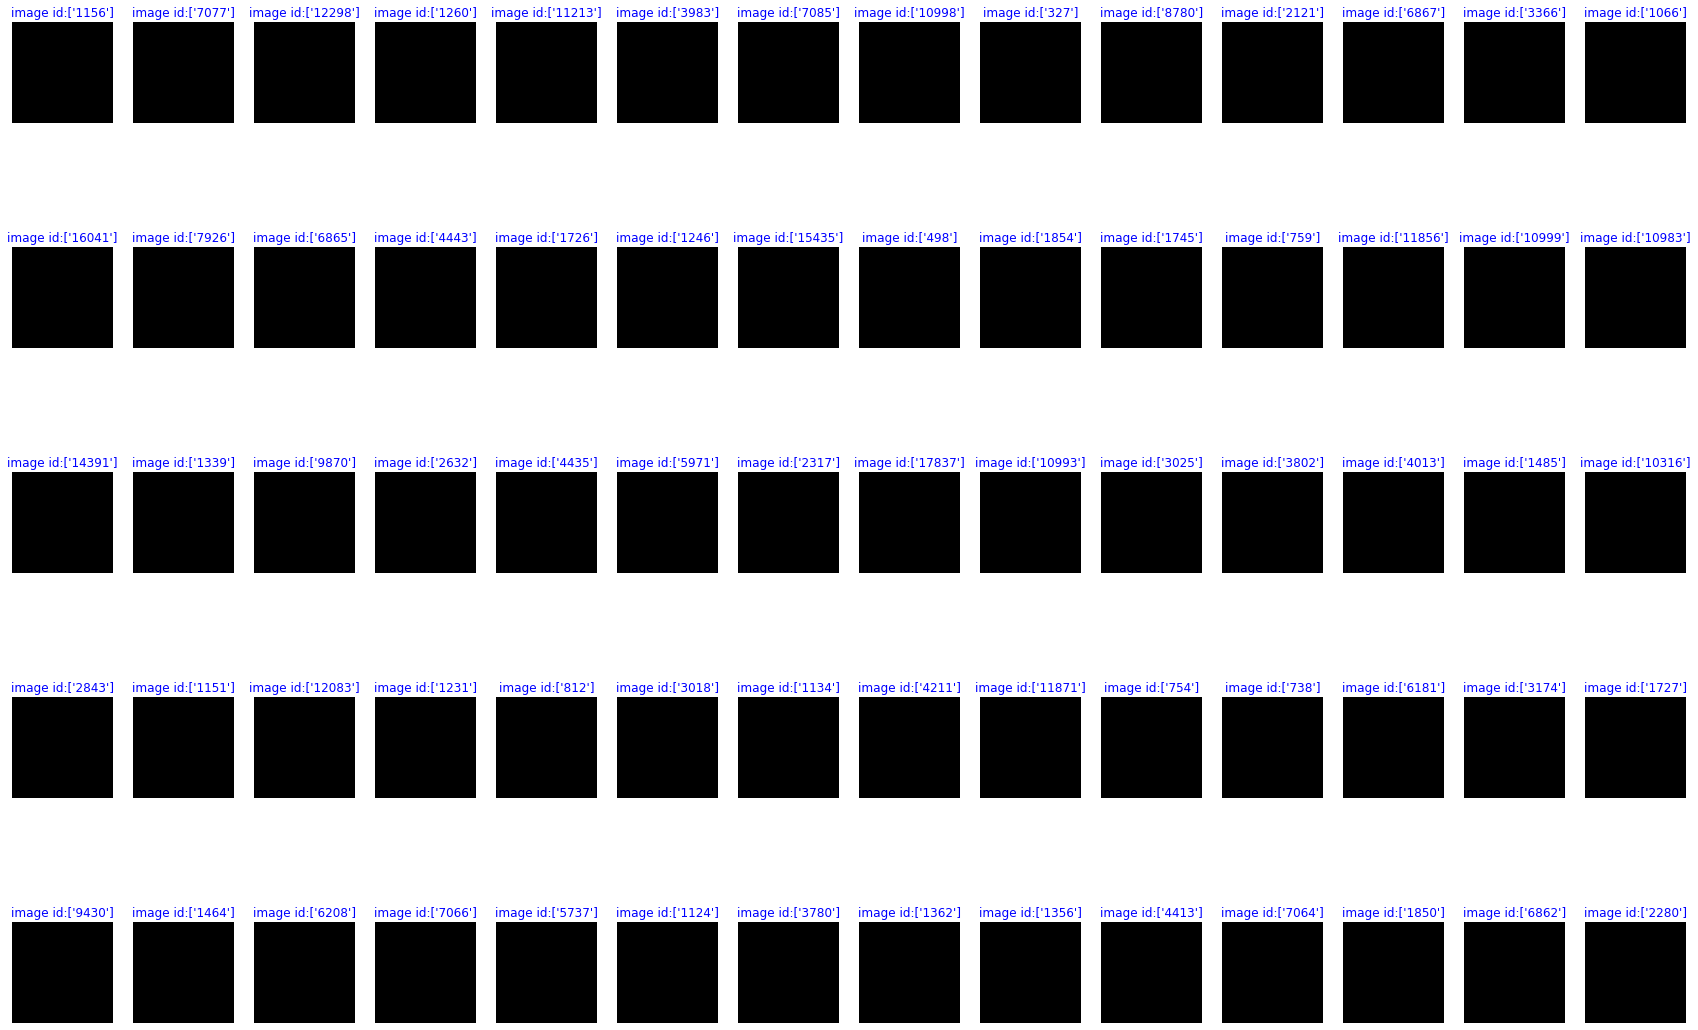

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from keras.preprocessing import image

plt.figure(figsize=(30,20))
num_subplots=70

for i in range(num_subplots):
  
  j=death_ids[i]
  plt.subplot(5,14,i+1)
  plt.imshow(image.array_to_img(images_to_remove[i]),cmap='binary', interpolation='bilinear')
  plt.axis('off')
  plt.title('image id:{}'.format([j]), fontsize=12, color='blue')

plt.show()

### 1.3.3. Remove

In [ ]:
for i in range(len(deathnote)):
  
  garbage= deathnote['filepath'][i]

  if os.path.isfile(garbage):
    os.remove(garbage)

In [ ]:
# Total Map Images after Data Pruning

filepaths=pd.Series(list(png_dr.glob(r'*.png')),name='filepath').astype(str)

filesize=pd.Series(filepaths.apply(lambda x: os.path.getsize(x)),name='filesize').astype(int)

images_pruned=pd.concat([filepaths, filesize],axis=1).sample(frac=1.0,random_state=1).reset_index(drop=True)
images_pruned